 # Usage example

This notebook demonstrates how to decorrelate radiographs, using a robust estimate
of the scintillator point-response function.

## 1. Simulate Poisson-Gaussian radiographs

We first create a data set of 20 Poisson-Gaussian noisy radiographs, blurred
by a Laplacian PRF. The noise model of the radiographs is
$$
    I = \text{Poisson}(h \ast I^0 \exp(-x)) + \text{Gaussian}(0, \sigma^2)
$$
where $I^0$ is the source intensity, $x$ the object, $h$ a convolution kernel,
$\sigma^2$ the variance of isotropic additive Gaussian noise.

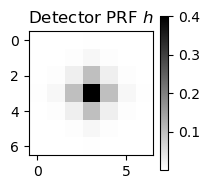

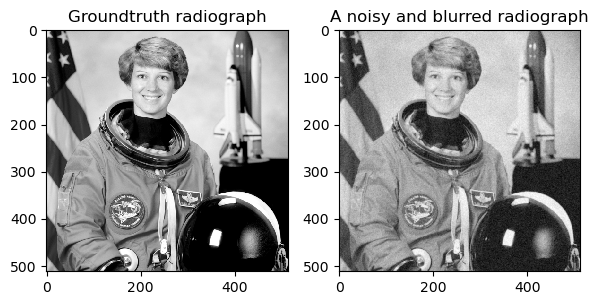

In [1]:
import numpy as np
from scintillatordecorrelator.simulate import (discretized_double_laplace,
                                               simulate_data)
from skimage.data import astronaut
import matplotlib.pyplot as plt
from skimage.color import rgb2gray

# 1. Simulate a PRF
h_shape = (7, 7)
h_true = discretized_double_laplace(h_shape, b=0.5)
h_true /= h_true.sum()

plt.figure(figsize=(2, 2))
plt.title('Detector PRF $h$')
plt.imshow(h_true, cmap='gray_r')  # Removed _r suffix to invert colors
plt.colorbar()
plt.show()

# 2. Simulate noisy radiographs using Beer-Lambert's law
im = rgb2gray(astronaut())
I_0 = 400  # source intensity
I_true = I_0 * np.exp(-im)  # Beer-Lambert's law
I_noisy = simulate_data(
    I_true,
    h_true,
    nr_ims=40,
    sigma=0) # magnitude of Gaussian additive noise

_, (ax1, ax2) = plt.subplots(1, 2, figsize=(6, 6))
ax1.imshow(I_true, cmap='gray_r', interpolation='none')  # Added _r suffix to invert colors
ax1.set_title('Groundtruth radiograph')
ax2.imshow(I_noisy[0], cmap='gray_r', interpolation='none')  # Added _r suffix to invert colors
ax2.set_title('A noisy and blurred radiograph')
plt.tight_layout()
plt.show()


In the simulation the following assumptions were made:

1. The radiographs are measured with reasonably high photon counts (here, 200 counts).
2. The amount of additive Gaussian is not too high (here, $\sigma=10$ was taken).
3. The PRF of the detector is uniform and not too large.

## 2. Estimating a robust deconvolution kernel

When the PRF is unknown, which is typically the case for X-ray detectors, it
can under some conditions be recovered via the estimation of a covariance matrix. There are several factors that play
a role in the quality of the estimate:
  - The number of static images;
  - The photon counts (higher is better) versus the level of Gaussian noise (lower is better);
  - The smoothness of structures in the image (smoother is better) and the size of the PRF (smaller is easier).

The first step is to determine an _auto-correlation kernel_, which is the convolution kernel of the covariance matrix.

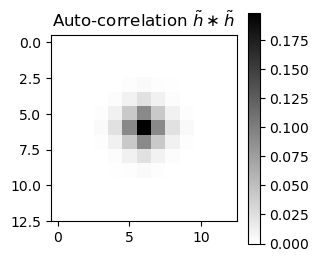

In [2]:
from scintillatordecorrelator import estimate_autocorrelation

# compute the auto-correlation kernel
h_conv_h = estimate_autocorrelation(
    I_noisy,
    out_shape=(13, 13),
    estimator='mean')

# plot
plt.figure(figsize=(3, 3))
plt.imshow(h_conv_h, cmap='gray_r')
plt.title('Auto-correlation $\\tilde h \\ast \\tilde h$')
plt.colorbar()
plt.show()

One way to solve the PRF $\tilde h$ from $\tilde h \ast \tilde h$ is to decompose a covariance matrix into convolution
operators. Any row or column of the convolution operator contains an estimate kernel.
This functionality is in `solve_prf` and demonstrated below.

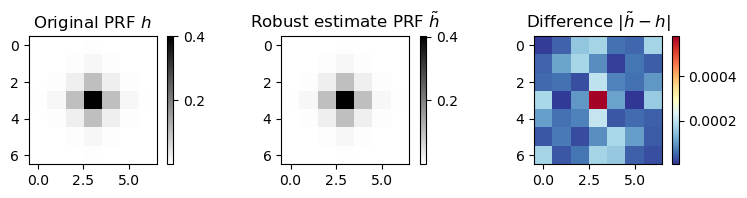

In [3]:
from scintillatordecorrelator import solve_kernel

# solve the PRF from the auto-correlation kernel
h_est = solve_kernel(h_conv_h)
h_est /= h_est.sum()

# plot
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(8, 2))
ax1.imshow(h_true, cmap='gray_r')
ax1.set_title('Original PRF $h$')
fig.colorbar(ax1.images[0], ax=ax1)
ax2.imshow(h_est, cmap='gray_r')
ax2.set_title('Robust estimate PRF $\\tilde h$')
fig.colorbar(ax2.images[0], ax=ax2)
ax3.imshow(np.abs(h_est - h_true), cmap='RdYlBu_r')
ax3.set_title('Difference $|\\tilde h - h|$')
fig.colorbar(ax3.images[0], ax=ax3)
plt.tight_layout()
plt.show()

Some remarks:
- When radiographs contain Gaussian additive noise, $\tilde h$ does not estimate
$h$, but is a more robust, regularized version of it. Here, it softens the
values around the central pixel. However, with pure Poisson
noise (set `sigma=0.0` in `simulate_data(...)`) the estimate
$\tilde h$ does approximate $h$.
- In practice, the error of $\tilde h$ is unknown. However, eyeballing
it usually gives a good impression. It must be radially symmetric,
and estimating it from different image regions should give
similar results.

## 3. Direct deconvolution => Decorrelation

The kernel $\tilde h$ may now be used to decorrelate noisy radiographs.
A simple, direct Fourier deconvolution method is used.

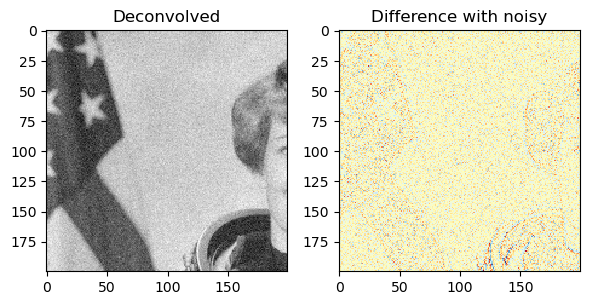

In [4]:
from scintillatordecorrelator import Deconvolve

# load the deconvolution class
deconv = Deconvolve(h_est)

# perform deconvolution
I_decorr = np.empty_like(I_noisy)
for i, im in enumerate(I_noisy):
    I_decorr[i, ...] = deconv(im)

# plot
plt.figure(figsize=(6, 6))
plt.subplot(1, 2, 1)
plt.imshow(I_decorr[0, :200, :200], cmap='gray_r', interpolation='none')
plt.title('Deconvolved')
plt.subplot(1, 2, 2)
plt.imshow(I_decorr[0, :200, :200] - I_noisy[0, :200, :200], cmap='RdYlBu_r',
           interpolation='none')
plt.title('Difference with noisy')
plt.tight_layout()
plt.show()

Great, that was it! Deconvolved images are ready for self-supervised (blind-spot) denoising.

 - Note that the difference `I_decorr - I_noisy`, that ensures there are no strong deconvolution artifacts,
can always be computed, even without groundtruth.
 - In this example, we applied the found kernel to the same data that was used as PRF-estimation data set. In
cone-beam set-ups with sufficient photon flux, the found PRF is
typically not signal-dependent and can therefore be applied to other radiographs acquired
with the same detector and the same experimental conditions.
 - Since only Poisson noise follows the convolution model, deconvolution of Gaussian noise leads to checkerboard
artifacts. These artifacts correlate pixels, thus cannot be removed trivially with blind-spot denoisers. However,
with high photon counts, the Gaussian component is typically small.

## 4. Check

A simple check to see if decorrelation worked well, is to repeat the PRF estimation
on the deconvolved data.

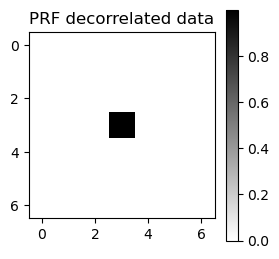

In [5]:
h_conv_h_decorr = estimate_autocorrelation(I_decorr, out_shape=(13, 13))
h_est_decorr = solve_kernel(h_conv_h_decorr)
h_est_decorr /= h_est_decorr.sum()

plt.figure(figsize=(3, 3))
plt.imshow(h_est_decorr, cmap='gray_r')
plt.title('PRF decorrelated data')
plt.colorbar()
plt.show()

The resulting PRF should show a simple dot, meaning that, on average,
pixels in the image do not correlate